<a href="https://colab.research.google.com/github/oussezz/Master_Results/blob/main/ViT_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sovit-123/vision_transformers.git
%cd vision_transformers

Cloning into 'vision_transformers'...
remote: Enumerating objects: 612, done.
remote: Counting objects: 100% (333/333), done.
remote: Compressing objects: 100% (242/242), done.
remote: Total 612 (delta 175), reused 213 (delta 89), pack-reused 279
Receiving objects: 100% (612/612), 25.77 MiB | 11.08 MiB/s, done.
Resolving deltas: 100% (332/332), done.
/content/vision_transformers


In [2]:
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/vision_transformers
  Preparing metadata (setup.py) ... done
  Created wheel for vision-transformers: filename=vision_transformers-0.1.1.0-py3-none-any.whl size=55839 sha256=30e74797fcf8f54885c9eb0464f6f329dcc739275a18a54e7439caed1d85c252
  Stored in directory: /tmp/pip-ephem-wheel-cache-ordj1f1b/wheels/db/87/51/ad39d99a4ddd263b0b6eddc048a426338fde648f1ae338b7f0
Successfully built vision-transformers


In [3]:
%cd ..

/content


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib
import torch.nn as nn
import torch.optim as optim
import os
import cv2
import numpy as np
import shutil

from tqdm import tqdm
from vision_transformers.models import vit

matplotlib.style.use('ggplot')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Directories.
PROJECT = 'FlameViTPretreined_lr_0.0005_3_6_2023'
RES_DIR = os.path.join('/content/drive/MyDrive/results', PROJECT)
if os.path.exists(RES_DIR):
    shutil.rmtree(RES_DIR)
os.makedirs(RES_DIR, exist_ok=True)
PLOT_DIR = os.path.join('/content/drive/MyDrive/plots', PROJECT)
os.makedirs(PLOT_DIR, exist_ok=True)
CKPT_DIR = os.path.join('/content/drive/MyDrive/checkpoints', PROJECT)
os.makedirs(CKPT_DIR, exist_ok=True)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")
epochs = 10
image_size=224

[INFO]: Computation device: cuda


In [8]:
RESIZE_TO = (image_size, image_size)

train_transform = transforms.Compose(
    [transforms.Resize(RESIZE_TO),
     transforms.RandAugment(num_ops=0),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
    ])
valid_transform = transforms.Compose(
    [transforms.Resize(RESIZE_TO),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
    ])

In [9]:
import zipfile

def unzip_file(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Example usage
zip_path = '/content/drive/MyDrive/Test.zip'  # Path to the zip file
  # Path where you want to extract the files

unzip_file(zip_path,".")

import zipfile

def unzip_file(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Example usage
zip_path = '/content/drive/MyDrive/Training.zip'  # Path to the zip file
  # Path where you want to extract the files

unzip_file(zip_path,".")


In [10]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder

# Define the transforms for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to the desired size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the image pixel values
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root, transform=transform)
        self.classes=['Fire','No_Fire']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

# Set the paths to your train and test folders
train_folder = 'Training'
test_folder = 'Test'

# Instantiate the custom datasets
train_dataset = CustomDataset(train_folder, transform=train_transform)
valid_dataset = CustomDataset(test_folder, transform=valid_transform)

# Set your desired batch size
batch_size = 16

# Create the data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


In [11]:
print(train_dataset.classes)

['Fire', 'No_Fire']


In [12]:
# instantiate the model
model = vit.vit_b_p16_224(
    image_size=224, pretrained=True
).to(device)
# print(model)

Loading vit_b_p16_224 pretrained weights


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 64.3MB/s]


Loading Torchvision pretrained weights


In [13]:
model.mlp_head = nn.Linear(in_features=768, out_features=2, bias=True)
_ = model.to(device)
print(model)

ViT(
  (patches): CreatePatches(
    (patch): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-11): 12 x ModuleList(
        (0): Normalization(
          (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (fn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (out): Sequential(
              (0): Linear(in_features=768, out_features=768, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): Normalization(
          (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (fn): MLP(
            (mlp_net): Sequential(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.0, inplace=False)
              (3): Linear(in_features=3072, out_features

In [14]:
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function
criterion = nn.CrossEntropyLoss()
# the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, 
                      weight_decay=0.0005)

[INFO]: 85,800,194 total parameters.
[INFO]: 85,800,194 trainable parameters.


In [15]:
# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1

        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc


In [16]:
# validation
def validate(model, testloader, criterion, classes):
    model.eval()
    
    # we need two lists to keep track of class-wise accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
                        
            if counter == 1:
                gt_color = (0, 255, 0)
                for i in range(image.shape[0]):
                    gt_class = classes[labels[i].cpu().numpy()]
                    pred_class = classes[preds[i].cpu().numpy()]
                    if gt_class == pred_class:
                        pred_color = gt_color
                    else:
                        pred_color = (0, 0, 255)
                    img_to_write = image[i].cpu()
                    img_to_write = img_to_write / 2 + 0.5
                    img_to_write = img_to_write.numpy()
                    img_to_write = np.transpose(img_to_write, (1, 2, 0))
                    img_to_write = cv2.resize(img_to_write, (224, 224))
                    img_to_write = cv2.cvtColor(img_to_write, cv2.COLOR_RGB2BGR)
                    cv2.putText(
                        img_to_write,
                        text=f"GT: {gt_class}",
                        org=(15, 25),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.75,
                        color=gt_color,
                        thickness=2,
                        lineType=cv2.LINE_AA
                    )
                    cv2.putText(
                        img_to_write,
                        text=f"PRED: {pred_class}",
                        org=(15, 60),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.75,
                        color=pred_color,
                        thickness=2,
                        lineType=cv2.LINE_AA
                    )
                    cv2.imwrite(
                        os.path.join(RES_DIR, 'image_batch'+str(counter)+'image'+str(i)+'.jpg'), 
                        img_to_write*255.
                    )

            # calculate the accuracy for each class
            correct  = (preds == labels).squeeze()
            for i in range(len(preds)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))

    # print the accuracy for each class after evey epoch
    # the values should increase as the training goes on
    print('\n')
    for i in range(2):
        print(f"Accuracy of {classes[i]}: {100*class_correct[i]/class_total[i]}")

    return epoch_loss, epoch_acc


In [17]:
# start the training
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")

    train_epoch_loss, train_epoch_acc = train(
        model, 
        train_dataloader,                                       
        optimizer, 
        criterion
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        valid_dataloader,  
        criterion,
        train_dataset.classes
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    print('\n')
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

    print('-'*50)


[INFO]: Epoch 1 of 10
Training


100%|██████████| 2461/2461 [20:34<00:00,  1.99it/s]


Validation


100%|██████████| 539/539 [02:06<00:00,  4.28it/s]




Accuracy of Fire: 84.97177340860425
Accuracy of No_Fire: 68.50574712643679


Training loss: 0.015, training acc: 99.553
Validation loss: 0.563, validation acc: 78.322
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training


100%|██████████| 2461/2461 [20:27<00:00,  2.00it/s]


Validation


100%|██████████| 539/539 [02:04<00:00,  4.34it/s]




Accuracy of Fire: 94.70508078645123
Accuracy of No_Fire: 24.137931034482758


Training loss: 0.004, training acc: 99.881
Validation loss: 1.210, validation acc: 66.206
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training


100%|██████████| 2461/2461 [20:27<00:00,  2.00it/s]


Validation


100%|██████████| 539/539 [02:03<00:00,  4.36it/s]




Accuracy of Fire: 93.69281681915515
Accuracy of No_Fire: 33.50574712643678


Training loss: 0.001, training acc: 99.975
Validation loss: 1.127, validation acc: 69.386
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training


100%|██████████| 2461/2461 [20:27<00:00,  2.01it/s]


Validation


100%|██████████| 539/539 [02:03<00:00,  4.36it/s]




Accuracy of Fire: 90.9090909090909
Accuracy of No_Fire: 56.724137931034484


Training loss: 0.001, training acc: 99.987
Validation loss: 0.759, validation acc: 77.103
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training


100%|██████████| 2461/2461 [20:28<00:00,  2.00it/s]


Validation


100%|██████████| 539/539 [02:03<00:00,  4.36it/s]




Accuracy of Fire: 93.36188436830835
Accuracy of No_Fire: 46.7816091954023


Training loss: 0.001, training acc: 99.987
Validation loss: 0.923, validation acc: 74.550
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training


100%|██████████| 2461/2461 [20:29<00:00,  2.00it/s]


Validation


100%|██████████| 539/539 [02:03<00:00,  4.35it/s]




Accuracy of Fire: 92.33015378625657
Accuracy of No_Fire: 51.293103448275865


Training loss: 0.000, training acc: 100.000
Validation loss: 0.833, validation acc: 75.757
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training


100%|██████████| 2461/2461 [20:28<00:00,  2.00it/s]


Validation


100%|██████████| 539/539 [02:04<00:00,  4.32it/s]




Accuracy of Fire: 93.05041853221725
Accuracy of No_Fire: 47.241379310344826


Training loss: 0.000, training acc: 100.000
Validation loss: 0.901, validation acc: 74.550
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training


100%|██████████| 2461/2461 [20:27<00:00,  2.01it/s]


Validation


100%|██████████| 539/539 [02:04<00:00,  4.33it/s]




Accuracy of Fire: 92.5637531633249
Accuracy of No_Fire: 50.172413793103445


Training loss: 0.000, training acc: 100.000
Validation loss: 0.844, validation acc: 75.444
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training


100%|██████████| 2461/2461 [20:27<00:00,  2.01it/s]


Validation


100%|██████████| 539/539 [02:04<00:00,  4.32it/s]




Accuracy of Fire: 91.6098890402959
Accuracy of No_Fire: 54.88505747126437


Training loss: 0.000, training acc: 100.000
Validation loss: 0.766, validation acc: 76.778
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training


100%|██████████| 2461/2461 [20:26<00:00,  2.01it/s]


Validation


100%|██████████| 539/539 [02:05<00:00,  4.30it/s]



Accuracy of Fire: 91.99922133540977
Accuracy of No_Fire: 52.52873563218391


Training loss: 0.000, training acc: 100.000
Validation loss: 0.803, validation acc: 76.059
--------------------------------------------------


In [18]:
# save the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            },  os.path.join(CKPT_DIR, 'vitmodel_0.0005.pth'))

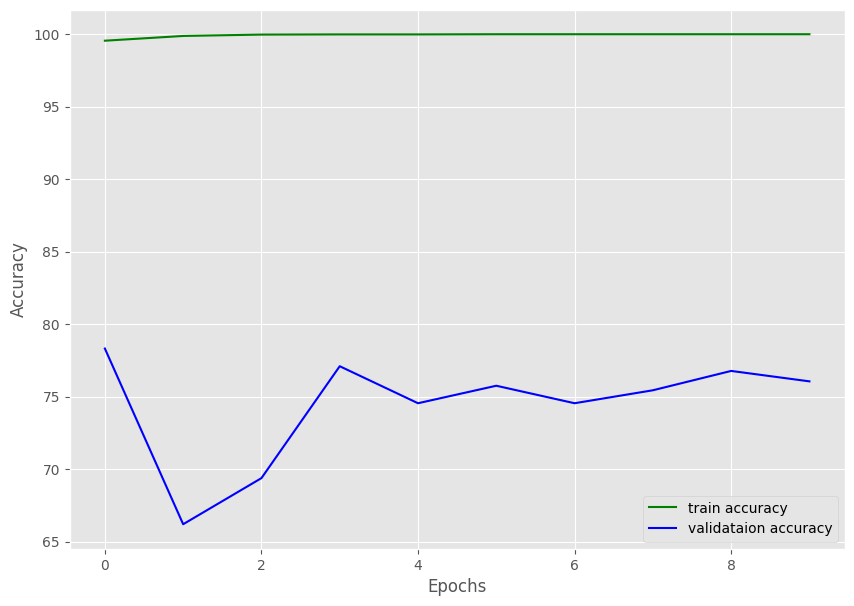

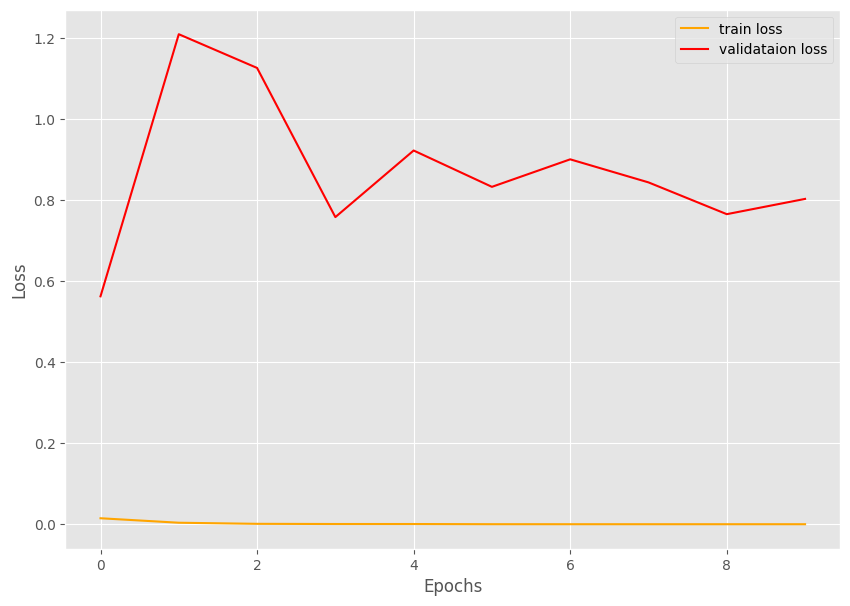

TRAINING COMPLETE


In [19]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-', 
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(PLOT_DIR, 'accuracy.png'))
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss'
)
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validataion loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(PLOT_DIR, 'loss.png'))
plt.show()
 
print('TRAINING COMPLETE')

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def validate(model, testloader, criterion, classes):
    model.eval()
    
    # we need two lists to keep track of class-wise accuracy
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))

    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

            

            # calculate the accuracy for each class
            correct = (preds == labels).squeeze()
            for i in range(len(preds)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))

    # print the accuracy for each class after every epoch
    # the values should increase as the training goes on
    print('\n')
    for i in range(len(classes)):
        print(f"Accuracy of {classes[i]}: {100*class_correct[i]/class_total[i]}")

    # calculate the confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(confusion_mat)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # calculate other metrics
    report = classification_report(all_labels, all_preds, target_names=classes)
    print("\nClassification Report:")
    print(report)

    return epoch_loss, epoch_acc


Validation


100%|██████████| 539/539 [02:11<00:00,  4.11it/s]




Accuracy of Fire: 91.99922133540977
Accuracy of No_Fire: 52.52873563218391

Confusion Matrix:
[[4726  411]
 [1652 1828]]


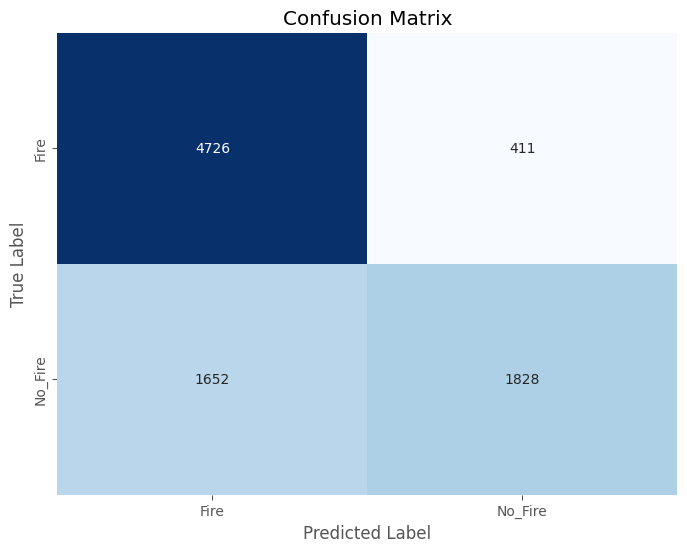


Classification Report:
              precision    recall  f1-score   support

        Fire       0.74      0.92      0.82      5137
     No_Fire       0.82      0.53      0.64      3480

    accuracy                           0.76      8617
   macro avg       0.78      0.72      0.73      8617
weighted avg       0.77      0.76      0.75      8617



In [28]:
valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        valid_dataloader,  
        criterion,
        train_dataset.classes
    )